In [1]:
# Importing libraries

import pandas as pd 
import numpy as np 
import yfinance as yf 
import empyrical as ep 
from pyfolio import timeseries
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

C:\anaconda3\envs\infertradenv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
# Imporing data

df1 = yf.download(tickers="AUDUSD=X", start="2010-01-01", end="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
# data AUDUSD is a forex data, so we will remove the Adjusted close and volume data keeping only OHLC

df1 = df1.rename(columns={"Close":"close", "Open":"open", "High":"high", "Low":"low"})
del df1["Adj Close"]
del df1["Volume"]
df1

,open,high,low,close
Date,,,,
2009-12-31,0.894614,0.901063,0.893176,0.898311
2010-01-01,0.898311,0.898473,0.897827,0.898473
2010-01-04,0.897424,0.913910,0.894214,0.912492
2010-01-05,0.912825,0.917347,0.909504,0.911826
2010-01-06,0.911826,0.921914,0.910415,0.920471
...,...,...,...,...
2019-12-25,0.692281,0.692713,0.691611,0.692185
2019-12-26,0.692800,0.694203,0.692185,0.692473
2019-12-27,0.694800,0.698600,0.694370,0.694637


In [4]:
# Creating seperate column for date from index for both data 

df1["date"] = df1.index

In [5]:
# returns
df1["return"] = df1["close"].pct_change()
df1 = df1.dropna()

In [6]:
df1["rolling_sharpe"]=timeseries.rolling_sharpe(returns=df1["return"],rolling_sharpe_window=12)
df1["return_sharpe"] = df1["rolling_sharpe"].pct_change()
df1 = df1.dropna() 

C:\anaconda3\envs\infertradenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\anaconda3\envs\infertradenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
# Using X as days

In [8]:
df1["Days"] = [x for x in range(1, df1.shape[0]+1)] 

In [9]:
# rolling regression

lookback= 10
actual = []
predicted = []
xtest = []
for i in range(lookback, df1.shape[0]):
    xval = df1["Days"].iloc[i-lookback:i].values.reshape(-1,1)
    yval = df1["return_sharpe"].iloc[i-lookback:i]
    reg = LinearRegression().fit(xval,yval)
    actual.append(df1["return_sharpe"].iloc[i])
    predicted.append(float(reg.predict(df1["Days"].iloc[i].reshape(-1,1))))
    xtest.append(i)

In [10]:
dr = pd.DataFrame(index=df1["close"].iloc[lookback:].index)
dr["Actual"] = actual
dr["Predicted"] = predicted
dr["close"] = df1["close"].iloc[lookback:]
dr

,Actual,Predicted,close
Date,,,
2010-02-02,-0.062216,-0.078096,0.887311
2010-02-03,0.405260,-0.872093,0.882223
2010-02-04,0.047194,-1.709723,0.868961
2010-02-05,-0.156878,-0.234972,0.868583
2010-02-08,-0.024734,-0.029385,0.863483
...,...,...,...
2019-12-25,-0.064392,-0.034819,0.692185
2019-12-26,0.126759,-0.381457,0.692473
2019-12-27,0.426648,0.235117,0.694637


In [11]:
dr["P_sig"] = np.where(dr["Predicted"]>0, 1, -1)

In [12]:
dr["allocation"] = np.where(dr["P_sig"]==1, 0.2, -0.2)

In [13]:
import sys
sys.path.append('../')

In [14]:
from infertrade.utilities.performance import calculate_portfolio_performance_python

In [15]:
dr_port=calculate_portfolio_performance_python(dr)

<AxesSubplot:xlabel='Date'>

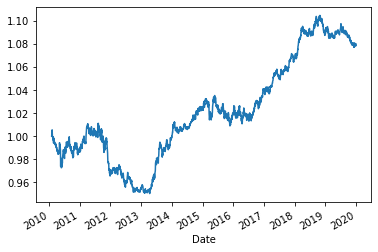

In [16]:
dr_port["portfolio_return"].plot()  

In [17]:
ep.sharpe_ratio(returns=dr_port["portfolio_return"].diff().fillna(1.0))

0.3366984257900341

In [18]:
from infertrade_pyfolio.wrapper import InfertradePyfolio

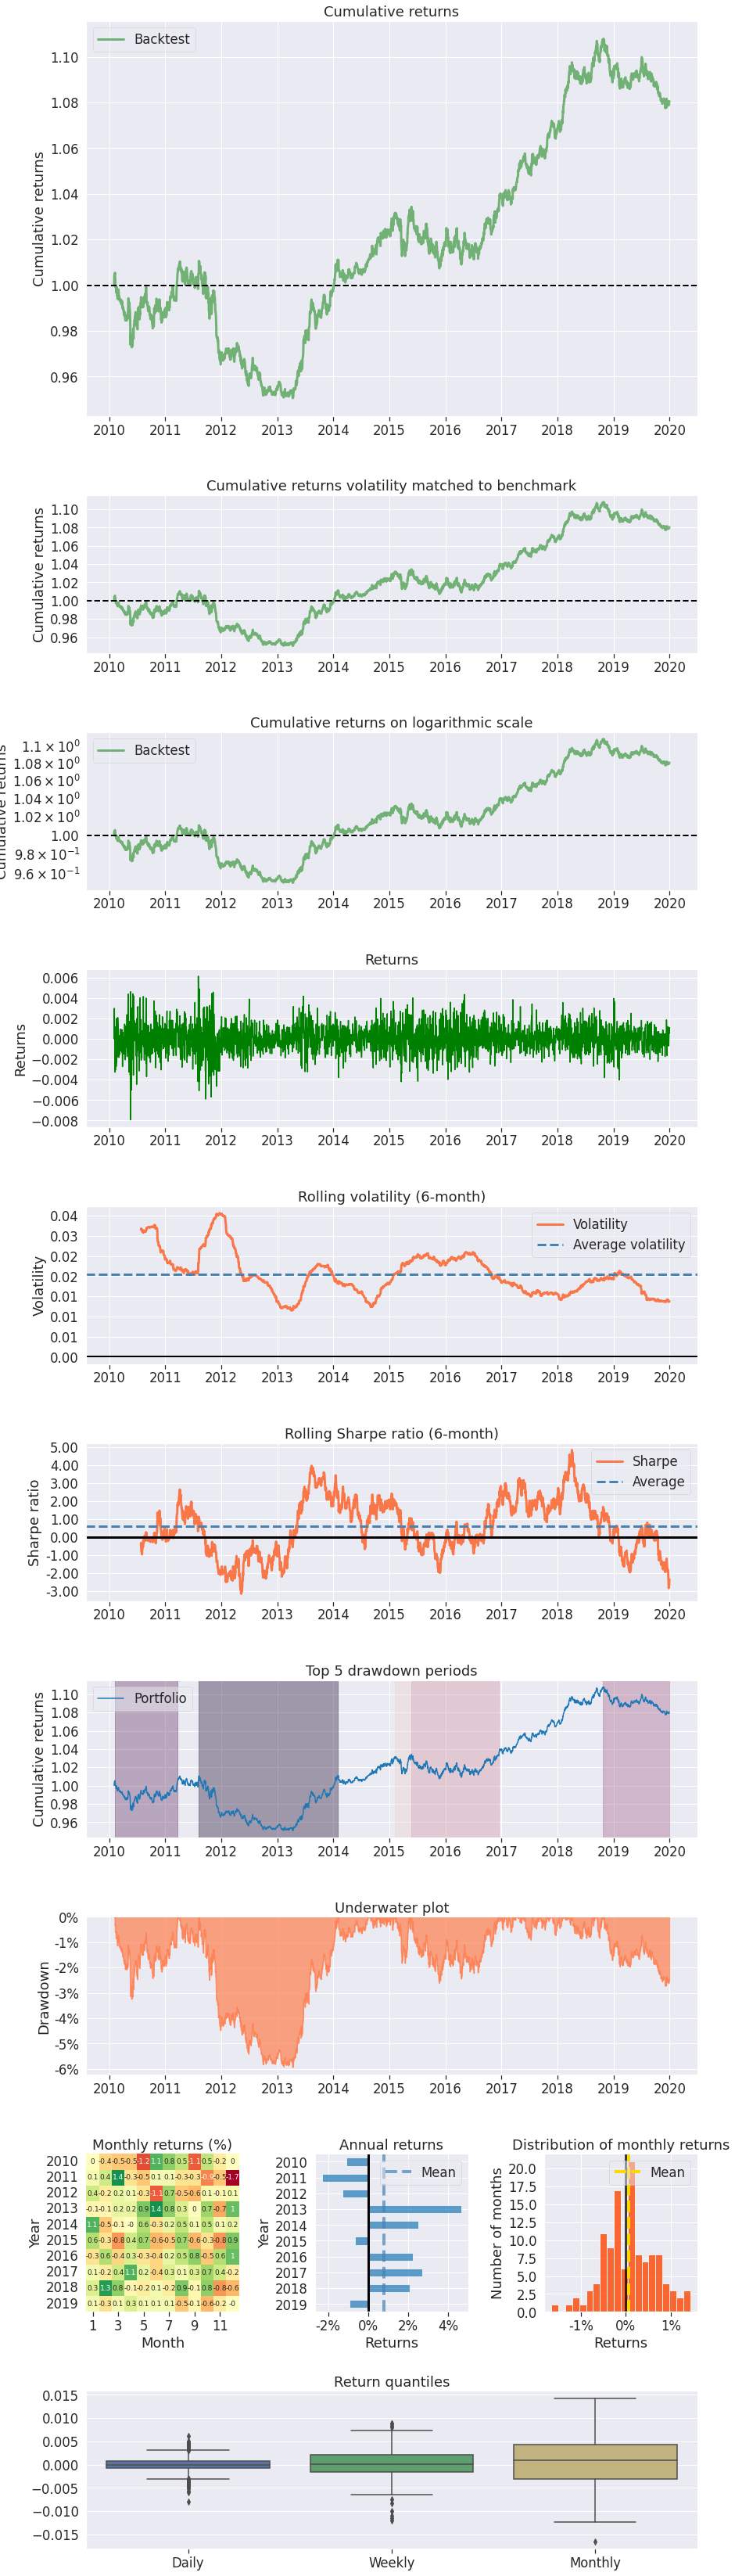

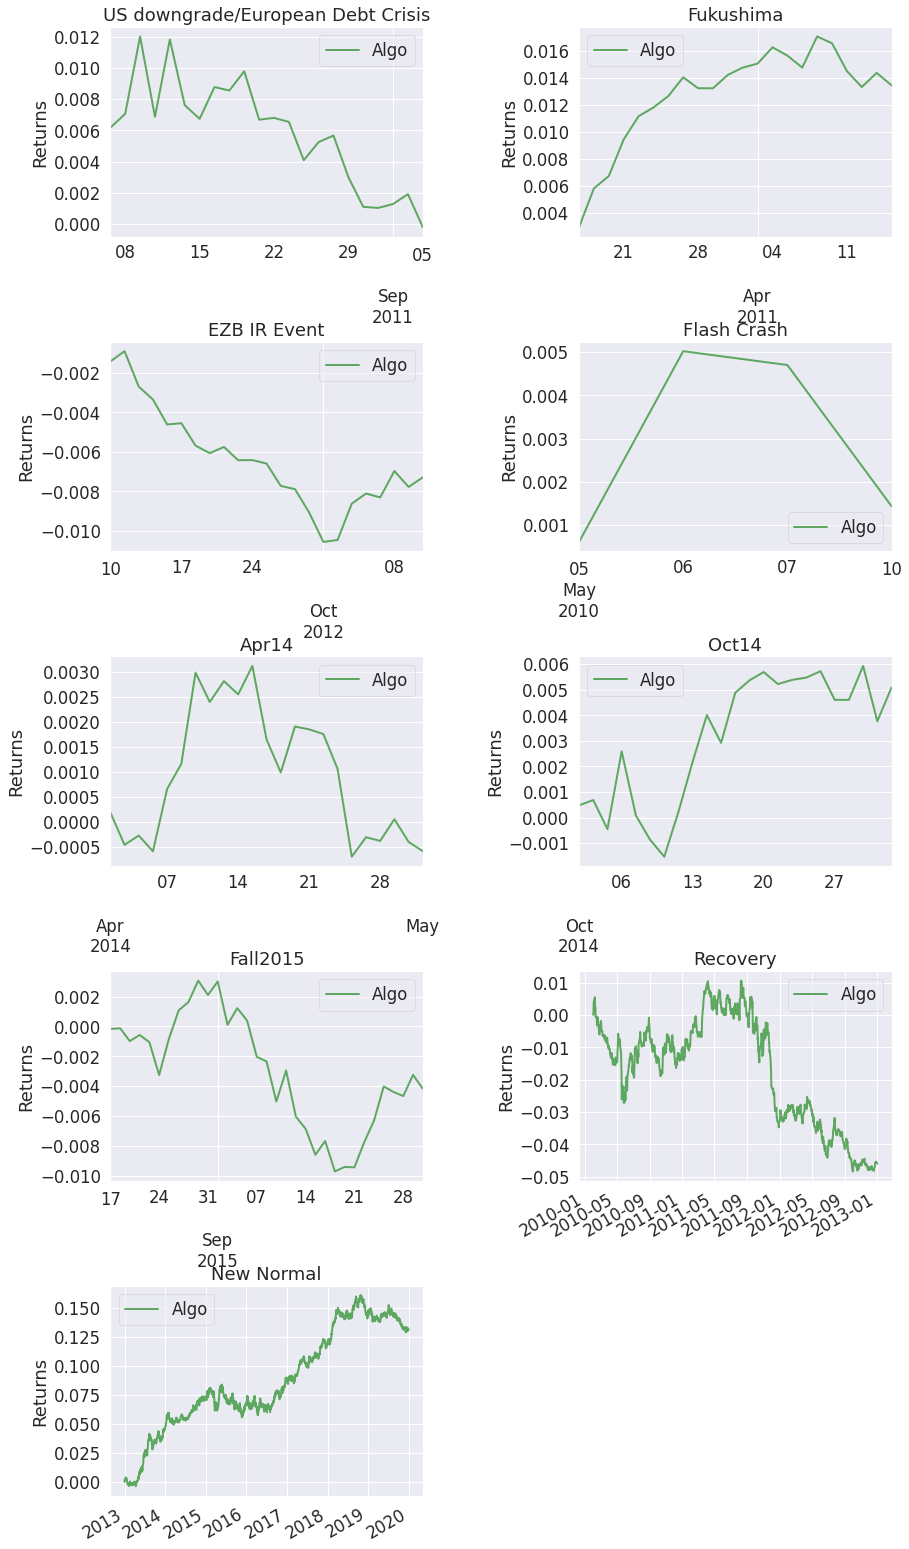

In [19]:
InfertradePyfolio.infertrade_full_tear_sheet(returns=dr_port["portfolio_return"].diff().fillna(0.0),
                                            notebook=True, pdf=False)